In [1]:
import numpy as np
import pandas as pd
import re
import itertools
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from wordcloud import WordCloud
import matplotlib.pyplot as plt

### Loading and Inspecting the data 

In [2]:
data = pd.read_csv('article.csv')
data.describe()

,title,link,published,description,category
count,188,188,188,188,188
unique,167,167,167,167,5
top,Firms 'going to war' against rivals on social ...,https://www.bbc.co.uk/news/business-62161520?a...,"Sun, 24 Jul 2022 23:15:44 GMT",The Department of Justice has already returned...,business
freq,2,2,2,2,73


In [3]:
data[['title', 'description']].head()

,title,description
0,Gas prices soar as Russia cuts German supply,The Nord Stream 1 pipeline is now operating at...
1,McDonald's puts up price of cheeseburger for f...,The fast food firm increases the price for the...
2,Train strikes: 'I'm missing the football becau...,Tens of thousands of rail workers are walking ...
3,Vow to tackle long waits to make a complaint,The financial regulator says new rules should ...
4,MPs call for debt repayments holiday for benef...,Households struggling through the cost-of-livi...


In [4]:
data.tail(10)

,title,link,published,description,category
178,Manchester United complete Lisandro Martinez s...,https://www.bbc.co.uk/sport/football/62262148?...,"Wed, 27 Jul 2022 12:25:49 GMT",Manchester United complete the signing of Arge...,sport
179,Commonwealth Games 2022: Adam Peaty puts rappe...,https://www.bbc.co.uk/sport/av/commonwealth-ga...,"Wed, 27 Jul 2022 07:16:42 GMT",Adam Peaty puts Birmingham rapper Mist through...,sport
180,Commonwealth Games 2022: Weightlifter Emily Ca...,https://www.bbc.co.uk/sport/av/commonwealth-ga...,"Wed, 27 Jul 2022 07:59:48 GMT",Weightlifter Emily Campbell talks about equali...,sport
181,Euro 2022: Does Alessia Russo deserve to start...,https://www.bbc.co.uk/sport/av/football/623140...,"Tue, 26 Jul 2022 22:46:42 GMT",Former England players Ian Wright and Alex Sco...,sport
182,Euro 2022: Watch all the angles of Alessia Rus...,https://www.bbc.co.uk/sport/av/football/623140...,"Tue, 26 Jul 2022 20:51:34 GMT",Watch all the angles as Alessia Russo scores a...,sport
183,Euro 2022: 'She's done it again!' Beth Mead's ...,https://www.bbc.co.uk/sport/av/football/623136...,"Tue, 26 Jul 2022 19:57:20 GMT","Watch Beth Mead's ""flawless"" finish as she ope...",sport
184,Euro 2022: Lucy Bronze doubles England's lead ...,https://www.bbc.co.uk/sport/av/football/623136...,"Tue, 26 Jul 2022 20:24:27 GMT",Watch defender Lucy Bronze double England's le...,sport
185,Euro 2022: Mary Earps' 'sensational' save deni...,https://www.bbc.co.uk/sport/av/football/623136...,"Tue, 26 Jul 2022 19:24:23 GMT","Watch Mary Earps' ""'sensational"" save as the E...",sport
186,Commonwealth Games 2022: Tom Dean and Kem Ceti...,https://www.bbc.co.uk/sport/av/commonwealth-ga...,"Tue, 26 Jul 2022 07:37:51 GMT",Double Olympic champion Tom Dean and TV person...,sport
187,What are the Commonwealth Games?,https://www.bbc.co.uk/sport/av/commonwealth-ga...,"Tue, 26 Jul 2022 05:52:33 GMT",Birmingham is preparing to host the Commonweal...,sport


### Feature Extraction

In [5]:
labels = data.category
true_k = np.unique(labels).shape[0]
true_k

5

In [6]:
def brew_soup(x):
    return ''.join(x['title']) + ' ' + ''.join(x['description'])

data['soup'] = data.apply(brew_soup, axis = 1)

In [7]:
# stopwords removal and stemming
porter_stemmer = PorterStemmer()

def stem_content(content):
    preview = re.sub('[^a-zA-Z]', ' ', content)
    preview = preview.lower()
    preview = preview.split()
    preview = [porter_stemmer.stem(word) for word in preview \
               if not word in stopwords.words('english')]
    preview = ' '.join(preview)
    return preview

In [8]:
data['soup'] = data['soup'].apply(stem_content)

In [9]:
data.soup.head()

0    ga price soar russia cut german suppli nord st...
1    mcdonald put price cheeseburg first time year ...
2    train strike miss footbal get ten thousand rai...
3    vow tackl long wait make complaint financi reg...
4    mp call debt repay holiday benefit claimant ho...
Name: soup, dtype: object

### Extracting keywords

In [10]:
tfidf = TfidfVectorizer(min_df = 5, max_df = 0.95, max_features = 8000, stop_words = 'english')
text = tfidf.fit_transform(data.soup)

In [11]:
model = KMeans(n_clusters=true_k, init = 'k-means++', max_iter = 200, n_init = 10)
model.fit(text)
labels = model.labels_
bbc_news_cluster = pd.DataFrame(list(zip(data.category, labels)), columns = ['category', 'cluster'])
print(bbc_news_cluster.copy().sort_values(by = ['cluster']))

                    category  cluster
0                   business        0
122               technology        0
121               technology        0
120               technology        0
118               technology        0
..                       ...      ...
142  science_and_environment        4
141  science_and_environment        4
140  science_and_environment        4
145  science_and_environment        4
107               technology        4

[188 rows x 2 columns]


In [12]:
# Top terms per cluster
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = tfidf.get_feature_names()
for i in range(0, true_k):
    print(f'Cluster: {i}'),
    for ind in order_centroids[i, :10]:
        print(f'{terms[ind]}')

Cluster: 0
peopl
price
live
comic
pay
cost
strike
musk
away
worker
Cluster: 1
help
tech
technolog
world
largest
use
water
new
suppli
million
Cluster: 2
firm
compani
social
uk
boss
media
say
googl
war
use
Cluster: 3
game
euro
england
sweden
commonwealth
final
player
semi
watch
big
Cluster: 4
say
new
year
make
long
climat
star
music
latest
rule


Cluster: 0


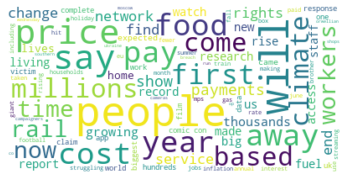

Cluster: 1


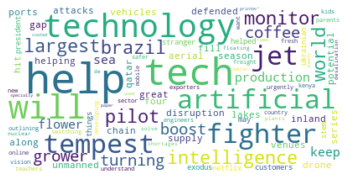

Cluster: 2


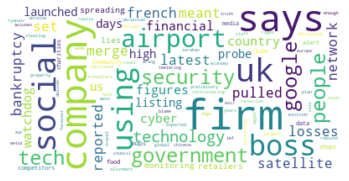

Cluster: 3


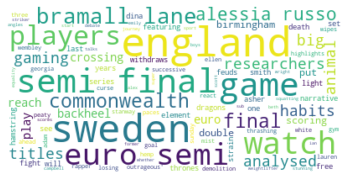

Cluster: 4


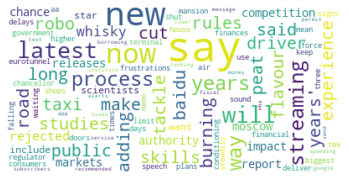

In [13]:
# word cloud
result = {'cluster':labels, 'description': data.description}
result = pd.DataFrame(result)
for  k in range(0, true_k):
    s = result[result.cluster == k]
    text = s['description'].str.cat(sep = ' ')
    text = text.lower()
    text = ' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size = 50,
                         max_words = 100,
                         background_color = "white").generate(text)
    print(f'Cluster: {k}')
    # print('Titles')
    # titles = bbc_news_cluster[bbc_news_cluster.cluster == k]['category']
    # print(titles.to_string(index =False))
    plt.figure()
    plt.imshow(wordcloud, interpolation = "bilinear")
    plt.axis("off")
    plt.show()

In [14]:
# prediction
def predict_new_document_cluster(text : str):
    text = stem_content(text)
    Y = tfidf.transform([text])
    prediction = model.predict(Y)
    print(f'The document belongs cluster {prediction}')

In [15]:
predict_new_document_cluster("Elon musk not to buy social network platform Twitter")
predict_new_document_cluster("Cryptocurrency bitcoin reaches a new low")
predict_new_document_cluster('Russia and Ukraine war hinder global supply chain of oil and wheat')
predict_new_document_cluster('Environment : Environmentalists concerned about soil polution and degradation. They are calling for renewed conservation measures')
predict_new_document_cluster('Soccer news : FC Barcelona player Frankie De Jong not signing for English football club Manchester United')
predict_new_document_cluster('Metropolitan Museum fashion gala (Met Gala) date')

The document belongs cluster [2]
The document belongs cluster [4]
The document belongs cluster [0]
The document belongs cluster [0]
The document belongs cluster [0]
The document belongs cluster [0]
